### Environment Setup: ModelNet & PyTorch3D

This section sets up the environment for 3D point cloud robustness experiments using PyTorch3D and ModelNet.

**Requirements:**
- PyTorch (with CUDA if available)
- PyTorch3D
- tqdm, matplotlib, numpy, pandas, scikit-learn

**Note:** PyTorch3D requires a compatible PyTorch version. See https://pytorch3d.org/docs/installation for details.

In [20]:
# Install PyTorch3D (uncomment if not already installed)
# For CUDA 11.7 (adjust for your CUDA version):
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

# If you are on CPU-only, use:
# pip install torch torchvision torchaudio
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
# PyTorch3D
try:
    import pytorch3d
    from pytorch3d.loss import chamfer_distance
    from pytorch3d.ops import sample_points_from_meshes
    print("PyTorch3D is installed and ready.")
except ImportError:
    print("PyTorch3D is not installed. Please follow the instructions above.")

PyTorch3D is installed and ready.


### Step 1: Download and Prepare ModelNet40 Data

We will download the ModelNet40 dataset, extract it, and preprocess it into point clouds.

- The dataset will be stored in a local directory (e.g., `./modelnet40`).
- Each mesh will be sampled into a fixed number of points (e.g., 1024) for use in point cloud classification.
- This step only needs to be run once.

In [3]:
import os
import urllib.request
import zipfile

DATA_DIR = './modelnet40'
MODELNET_URL = 'http://modelnet.cs.princeton.edu/ModelNet40.zip'
ZIP_PATH = os.path.join(DATA_DIR, 'ModelNet40.zip')

# Download ModelNet40 if not present
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR, 'ModelNet40')):
    print('Downloading ModelNet40...')
    urllib.request.urlretrieve(MODELNET_URL, ZIP_PATH)
    print('Extracting ModelNet40...')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print('Done.')
else:
    print('ModelNet40 already downloaded and extracted.')

ModelNet40 already downloaded and extracted.


### Step 2: Create a PyTorch Dataset and DataLoader for ModelNet40 Point Clouds

This step defines a PyTorch Dataset that loads ModelNet40 meshes, samples point clouds using PyTorch3D, and provides them for training and evaluation.

- Each sample is a tuple: (point_cloud [N, 3], label)
- The dataset supports on-the-fly mesh loading and point sampling.
- You can cache sampled point clouds for faster subsequent runs.

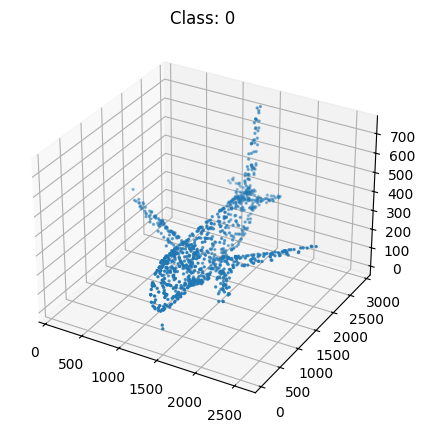

In [4]:
import glob
from torch.utils.data import Dataset, DataLoader
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
import trimesh
import warnings

class ModelNet40PointCloudDataset(Dataset):
    def __init__(self, root_dir, split='train', num_points=1024, cache=True, random_seed=42):
        self.root_dir = root_dir
        self.split = split
        self.num_points = num_points
        self.cache = cache
        self.random = np.random.RandomState(random_seed)
        self.mesh_paths = []
        self.labels = []
        self.class_map = {}
        self._build_file_list()
        self._cache = {} if cache else None

    def _build_file_list(self):
        classes = sorted([d for d in os.listdir(os.path.join(self.root_dir, 'ModelNet40')) if os.path.isdir(os.path.join(self.root_dir, 'ModelNet40', d))])
        self.class_map = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            split_dir = os.path.join(self.root_dir, 'ModelNet40', cls, self.split)
            if not os.path.exists(split_dir):
                continue
            for off_file in glob.glob(os.path.join(split_dir, '*.off')):
                self.mesh_paths.append(off_file)
                self.labels.append(self.class_map[cls])

    def __len__(self):
        return len(self.mesh_paths)

    def __getitem__(self, idx):
        if self.cache and idx in self._cache:
            return self._cache[idx]
        mesh_path = self.mesh_paths[idx]
        try:
            # Load mesh using trimesh
            mesh = trimesh.load(mesh_path)
            verts = torch.tensor(mesh.vertices, dtype=torch.float32)
            faces = torch.tensor(mesh.faces, dtype=torch.int64)
            
            if verts.shape[0] < self.num_points or faces.shape[0] == 0:
                raise ValueError("Mesh has too few vertices or faces.")
            
            mesh = Meshes(verts=[verts], faces=[faces])
            points = sample_points_from_meshes(mesh, self.num_points)[0]  # [N, 3]
            
            if torch.isnan(points).any() or torch.isinf(points).any():
                raise ValueError("Sampled points contain NaN or Inf.")
            label = self.labels[idx]
            sample = (points, label)
            if self.cache:
                self._cache[idx] = sample
            return sample
        except Exception as e:
            warnings.warn(f"Error loading item {idx}, path: {mesh_path}: {e}")
            # Return a dummy sample (random points, random label) to keep DataLoader running
            points = torch.randn(self.num_points, 3)
            label = 0
            return (points, label)

train_dataset = ModelNet40PointCloudDataset('./modelnet40', split='train', num_points=1024)
test_dataset = ModelNet40PointCloudDataset('./modelnet40', split='test', num_points=1024)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Visualize a sample point cloud
points, label = train_dataset[0]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), points[:, 2].cpu(), s=2)
ax.set_title(f'Class: {label}')
plt.show()

### Step 3: Define a Custom Point Cloud Classification Model

We define a simple custom model for point cloud classification. This model uses shared MLPs (1D convolutions), global max pooling, and fully connected layers.

- Input: point cloud of shape (B, N, 3)
- Output: logits for each class (B, num_classes)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplePointNet(nn.Module):
    def __init__(self, num_classes=40, input_dim=3):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(input_dim, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        # x: (B, N, 3)
        x = x.transpose(2, 1)  # (B, 3, N)
        x = self.mlp1(x)      # (B, 256, N)
        x = torch.max(x, 2)[0]  # (B, 256)
        x = self.fc(x)
        return x

### Step 4: Adversarial Attacks and Corruptions for Point Clouds

This section implements:
- FGSM and PGD adversarial attacks for point clouds
- Simple weather corruptions (Gaussian noise, snow, fog)

All functions operate on torch tensors of shape (B, N, 3).

In [6]:
import torch
import torch.nn.functional as F
import numpy as np

# --- Adversarial Attacks ---
def fgsm_attack(model, points, labels, epsilon):
    """
    FGSM attack for point clouds.
    Args:
        model: classification model
        points: (B, N, 3) input point cloud
        labels: (B,) ground truth labels
        epsilon: attack strength
    Returns:
        perturbed_points: (B, N, 3)
    """
    points_adv = points.clone().detach().requires_grad_(True)
    outputs = model(points_adv)
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    grad = points_adv.grad.data
    perturbed_points = points + epsilon * grad.sign()
    return perturbed_points.detach()

def pgd_attack(model, points, labels, epsilon, alpha, num_iter):
    """
    PGD attack for point clouds.
    Args:
        model: classification model
        points: (B, N, 3)
        labels: (B,)
        epsilon: max perturbation
        alpha: step size
        num_iter: number of steps
    Returns:
        perturbed_points: (B, N, 3)
    """
    ori_points = points.clone().detach()
    perturbed = ori_points + torch.empty_like(ori_points).uniform_(-epsilon, epsilon)
    perturbed.requires_grad = True
    for _ in range(num_iter):
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        grad = perturbed.grad.data
        perturbed = perturbed + alpha * grad.sign()
        perturbed = torch.max(torch.min(perturbed, ori_points + epsilon), ori_points - epsilon)
        perturbed = perturbed.detach().requires_grad_(True)
    return perturbed.detach()

# --- Weather Corruptions ---
def add_gaussian_noise(points, sigma=0.02):
    """Add Gaussian noise to point cloud (B, N, 3)."""
    noise = torch.randn_like(points) * sigma
    return points + noise

def add_snow(points, density=0.1, snow_height=0.15):
    """Simulate snow by randomly dropping points above a certain z threshold."""
    B, N, _ = points.shape
    mask = (points[..., 2] < (1.0 - snow_height)).float()
    keep = (torch.rand(B, N, device=points.device) > density).float()
    mask = mask * keep
    # Set dropped points to zero (or random noise)
    noisy_points = points * mask.unsqueeze(-1)
    return noisy_points

def add_fog(points, fog_strength=0.15):
    """Simulate fog by adding random noise and reducing contrast."""
    center = points.mean(dim=1, keepdim=True)
    fog = (points - center) * (1 - fog_strength) + center
    fog += torch.randn_like(points) * (fog_strength / 2)
    return fog


### Step 5: Training and Evaluation Pipeline

This section provides a simple training and evaluation loop for the custom model, supporting clean, adversarial, and corrupted data.

You can toggle between clean, adversarial, and corrupted training/evaluation by changing the `mode` argument.

In [ ]:
import torch.optim as optim
import traceback

# First, let's fix the dataset's __getitem__ method to handle errors better
def safe_getitem(self, idx):
    try:
        if self.cache and idx in self._cache:
            return self._cache[idx]
        mesh_path = self.mesh_paths[idx]
        mesh = trimesh.load(mesh_path)
        verts, faces = torch.from_numpy(mesh.vertices).float(), torch.from_numpy(mesh.faces).long()
        mesh = Meshes(verts=[verts], faces=[faces])
        points = sample_points_from_meshes(mesh, self.num_points)[0]  # [N, 3]
        label = self.labels[idx]
        sample = (points, label)
        if self.cache:
            self._cache[idx] = sample
        return sample
    except Exception as e:
        print(f"Error loading item {idx}, path: {self.mesh_paths[idx]}: {str(e)}")
        # Return a dummy sample of correct shape as fallback
        dummy_points = torch.zeros((self.num_points, 3))
        return dummy_points, 0

# Apply the patched method to the dataset class
ModelNet40PointCloudDataset.__getitem__ = safe_getitem

# Create new data loaders with fewer workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

def train_one_epoch(model, loader, optimizer, device, mode='clean', attack_params=None, corruption_fn=None):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0
    for points, labels in loader:
        points, labels = points.to(device), labels.to(device)
        optimizer.zero_grad()
        # Apply adversarial or corruption if needed
        if mode == 'fgsm':
            points = fgsm_attack(model, points, labels, **attack_params)
        elif mode == 'pgd':
            points = pgd_attack(model, points, labels, **attack_params)
        elif mode == 'corrupt' and corruption_fn is not None:
            points = corruption_fn(points)
        # ...else: clean
        outputs = model(points)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * points.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += points.size(0)
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

def evaluate(model, loader, device, mode='clean', attack_params=None, corruption_fn=None):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for points, labels in loader:
            points, labels = points.to(device), labels.to(device)
            # Apply adversarial or corruption if needed
            if mode == 'fgsm':
                points = fgsm_attack(model, points, labels, **attack_params)
            elif mode == 'pgd':
                points = pgd_attack(model, points, labels, **attack_params)
            elif mode == 'corrupt' and corruption_fn is not None:
                points = corruption_fn(points)
            outputs = model(points)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item() * points.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += points.size(0)
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

# Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplePointNet(num_classes=40).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Clean training
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, mode='clean')
    val_loss, val_acc = evaluate(model, test_loader, device, mode='clean')
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# Adversarial training (FGSM example)
# for epoch in range(epochs):
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, mode='fgsm', attack_params={'epsilon':0.02})
#     val_loss, val_acc = evaluate(model, test_loader, device, mode='fgsm', attack_params={'epsilon':0.02})
#     print(f"[FGSM] Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# Corruption training (Gaussian noise example)
# for epoch in range(epochs):
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, mode='corrupt', corruption_fn=lambda x: add_gaussian_noise(x, sigma=0.02))
#     val_loss, val_acc = evaluate(model, test_loader, device, mode='corrupt', corruption_fn=lambda x: add_gaussian_noise(x, sigma=0.02))
#     print(f"[Noise] Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


Error loading item 3626, path: ./modelnet40/ModelNet40/cone/train/cone_0117.off: invalid multinomial distribution (encountering probability entry = infinity or NaN)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105d8a030>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
